# Debugging and sanity checks of f4 ration Nea. estimates

In [1]:
suppressMessages({

library(tidyverse)
library(admixr)

source("../R/utils.R")

})

In [2]:
library(devtools)
reload(inst("admixr"))

Reloading installed admixr


In [3]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [4]:
load("../RData/admixtools_debugging.RData")

# Tests on Qiaomei's data

In [5]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"

EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

SNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.snp")
GENO_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.geno")
IND_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.ind")

BADSNP_FILE <- paste0(EIGENSTRAT_DIR, "UPA_merged_all.transitions.snp")

Create a `badsnp` file containing transition SNPs:

In [5]:
read_snp(SNP_FILE) %>% 
    keep_transitions %>%
    filter(chrom %in% 1:22) %>%
    write_tsv(BADSNP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  alt = col_character(),
  ref = col_character()
)


## Old vs new processing of Altai

In [6]:
old_vs_new <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(old_altai=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(new_altai=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, old_altai, new_altai, pop)

Joining, by = "name"


Warning message:
“Removed 5 rows containing missing values (geom_point).”

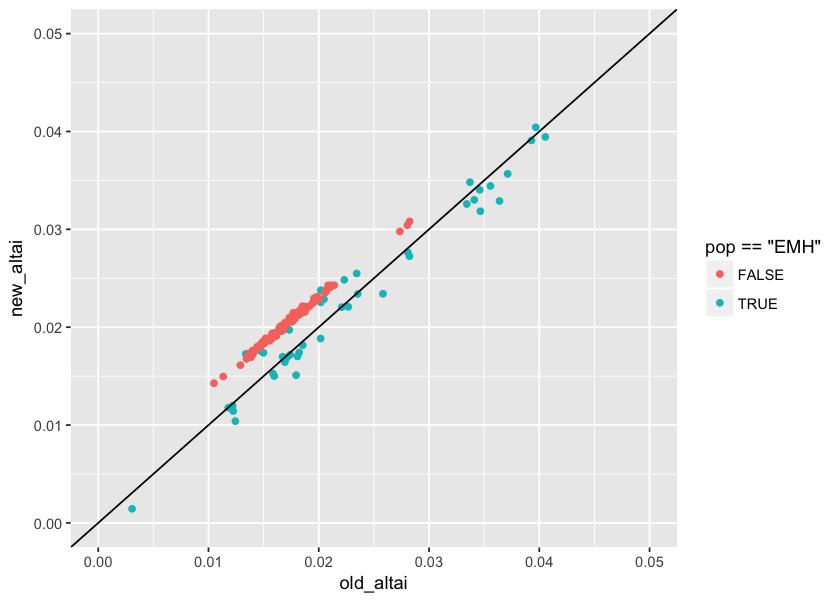

In [6]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(old_vs_new, aes(old_altai, new_altai, color=pop == "EMH")) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05)

**TODO** Partition the EMH samples based on their library prep method.

## Old vs new processing of Altai - transversions only

In [8]:
tv_old_vs_new <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(old_tv_only=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(new_tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, old_tv_only, new_tv_only, pop)

Joining, by = "name"


Warning message:
“Removed 13 rows containing missing values (geom_point).”

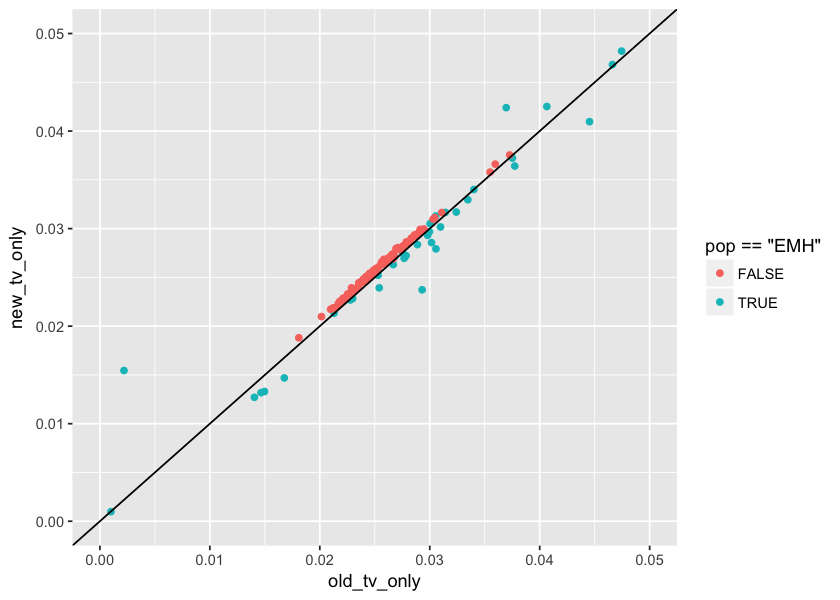

In [7]:
options(repr.plot.width=7, repr.plot.height=5)

ggplot(tv_old_vs_new, aes(old_tv_only, new_tv_only, color=pop == "EMH")) +
    geom_point() +
    geom_abline(slope=1) +
    ylim(0, 0.05) + xlim(0, 0.05)

The processing of Altai does not matter as long as we restrict to transversions only. Compare this to the previous plot, where there was a big difference in old vs new Altai processing.

This indicates that it really is a different way of calling genotypes in Altai vs Vindija that messes up things in the f4 ratio calculation.

## new Altai - Transversions-only vs all SNPs

In [10]:
tv_vs_all <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(all_snps=alpha),
    qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, all_snps, tv_only, pop)

Joining, by = "name"


## Transversions-only vs all SNPs

In [12]:
old_tv_vs_all <- inner_join(
    by="X",
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT) %>% rename(all_snps=alpha),
    qpF4ratio(X=samples$name, A="Altai", B="new_Vindija", C="Mbuti", O="Chimp", prefix=EIGENSTRAT, badsnp=BADSNP_FILE) %>% rename(tv_only=alpha),
) %>%
    rename(name=X) %>% 
    inner_join(samples) %>%
    select(name, all_snps, tv_only, pop)

Joining, by = "name"


Obviously, since TV-only results are perfectly correlated between old and new processing, this result looks the same as the one directly above.

## Does "manual" f4 calculation result in the same thing as `qpF4ratio` estimate?

#### Use two individual f4 statistics to calculate the f4 ratio of Nea. ancestry

In [14]:
num <- qpDstat(W=filter(samples, pop == "WestEurasia")$name, X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, f4mode=TRUE)

In [15]:
den <- qpDstat(W="new_Vindija", X="Mbuti", Y="new_Altai", Z="Chimp",
               prefix=EIGENSTRAT, f4mode=TRUE)

In [16]:
two_f4 <- mutate(num, alpha=Dstat/den$Dstat) %>% rename(two_f4=alpha)

#### Calculate the f4 ratios on the same set of samples

In [17]:
f4_ratio <- qpF4ratio(X=filter(samples, pop == "WestEurasia")$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                      prefix=EIGENSTRAT) %>%
    rename(f4_ratio=alpha)

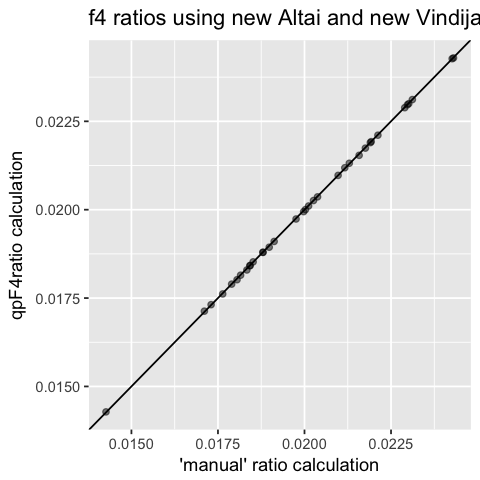

In [8]:
options(repr.plot.width=4, repr.plot.height=4)

inner_join(two_f4, f4_ratio, by=c("W"="X")) %>%
ggplot(aes(two_f4,  f4_ratio)) +
    geom_point(alpha=1/2) +
    geom_abline(slope=1) +
    labs(title="f4 ratios using new Altai and new Vindija",
         x="'manual' ratio calculation", y="qpF4ratio calculation")

Both approaches give exactly the same result (as expected). So I can use the individual f4 for debugging purposes.

<br><br><br><br><br><br>

Load Steffi's results:

In [135]:
suppressMessages({
    
steffi_df <- bind_rows(
    read_table2("../raw_data/old_steffi_results/results_usti_test/f4_ratios") %>% mutate(set="steffi_f4_vcf_all"),
    read_table2("../raw_data/old_steffi_results/results_usti_test_array/f4_ratios") %>% mutate(set="steffi_f4_vcf_intersect"),
    read_table2("../raw_data/old_steffi_results/results_qiamoei_dtoolbox/f4_ratios") %>% mutate(pop3=ifelse(pop3 == "AltaiNeandertal", "Altai", pop3), set="steffi_f4_qiaomei_all")
    ) %>% 
    filter(pop3 == "Altai", pop2 == "Mbuti") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    left_join(samples, by=c("pop1"="name")) %>%
    rename(name=pop1)

steffi_f4 <- steffi_df %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio)

})

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 on her whole VCF

In [394]:
my_f4_qiaomei_all <- qpF4ratio(X=samples$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                         prefix=EIGENSTRAT) %>% rename(my_f4_qiaomei_all=alpha)

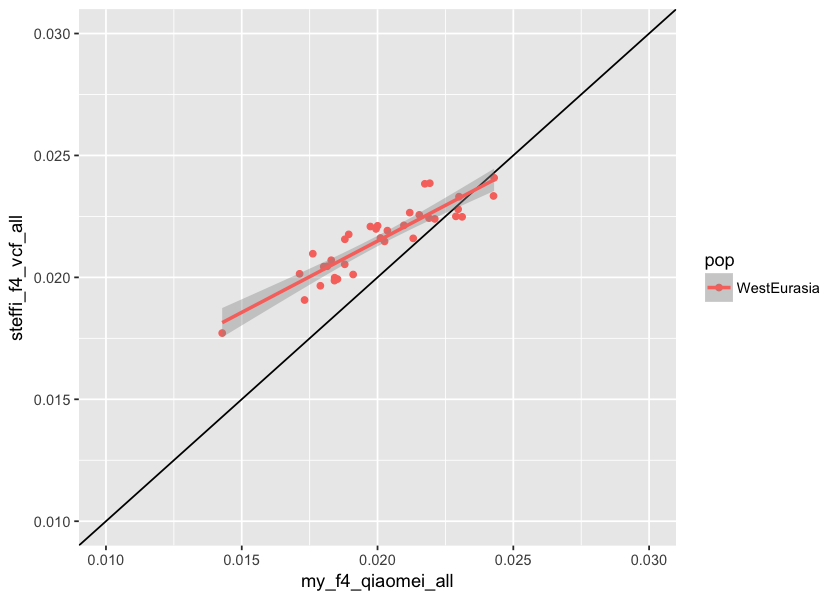

In [10]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_vcf_all, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## Steffi's f4 on her VCF vs Steffi's f4 on Qiaomei's 2.2M sites

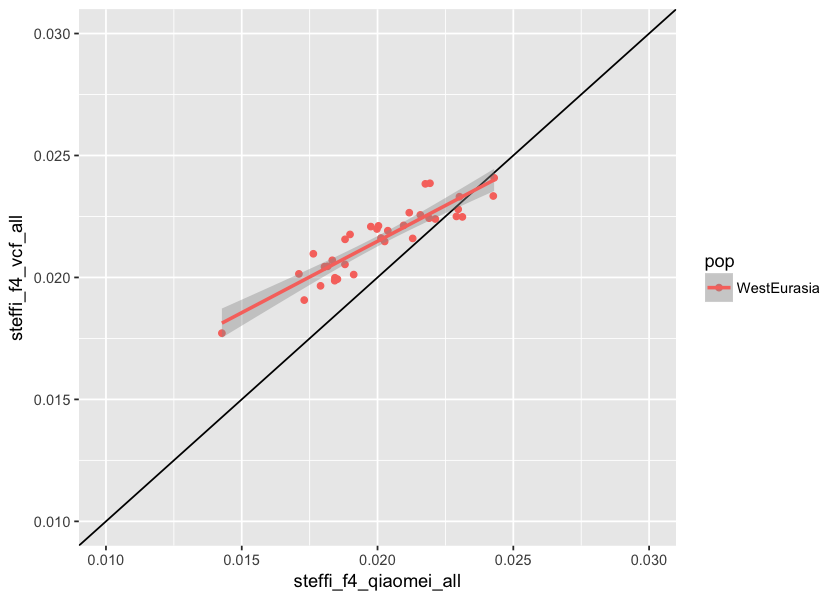

In [11]:
options(repr.plot.width=7, repr.plot.height=5)

steffi_f4  %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(steffi_f4_qiaomei_all, steffi_f4_vcf_all, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 Qiaomei's 2.2M sites (VCF made from EIGENSTRAT)

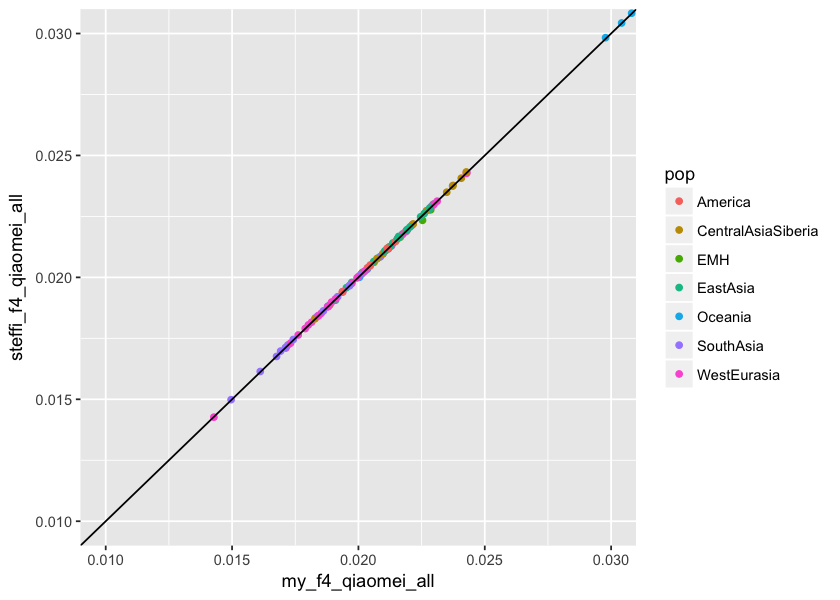

In [12]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name"))  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_qiaomei_all, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## My f4 on Qiaomei's 2.2M sites vs Steffi's f4 on her VCF intersect (~250k of sites)

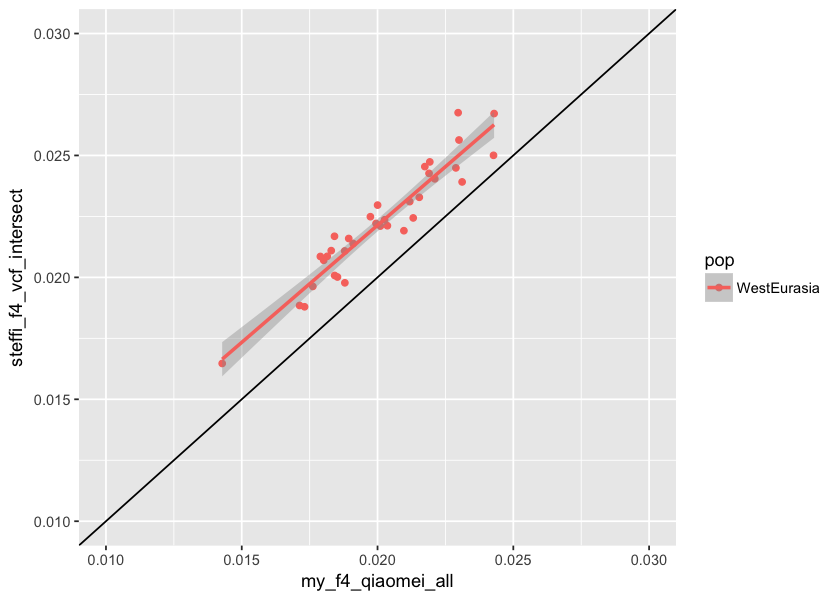

In [13]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_all, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_all, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

Intersect leads to a pretty nice correlation - it probably means the other sites that don't overlap (not those 250k overlapping) are weird in some way.

## My f4 on Steffi's 250k sites VCF subset vs Steffi's f4 on the same data

This uses the same data (EIGENSTRAT generated from VCF and the VCF itself).

**Any potential difference is caused by the computation of Admixtools vs Steffi's script.**

In [20]:
EIGENSTRAT_DIR <- "../raw_data/merged_vcfs/"
STEFFI_EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "almostvcf_steffi")

STEFFI_EIGENSTRAT_INTERSECT <- paste0(STEFFI_EIGENSTRAT, "_intersect")

In [ ]:
suppressMessages(
    subset_sites(STEFFI_EIGENSTRAT, STEFFI_EIGENSTRAT_INTERSECT, pos_file="../raw_data/eigenstrat_all/sites.pos")
)

In [398]:
my_f4_vcf_intersect <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                                 prefix=STEFFI_EIGENSTRAT_INTERSECT) %>% 
    rename(my_f4_vcf_intersect=alpha)

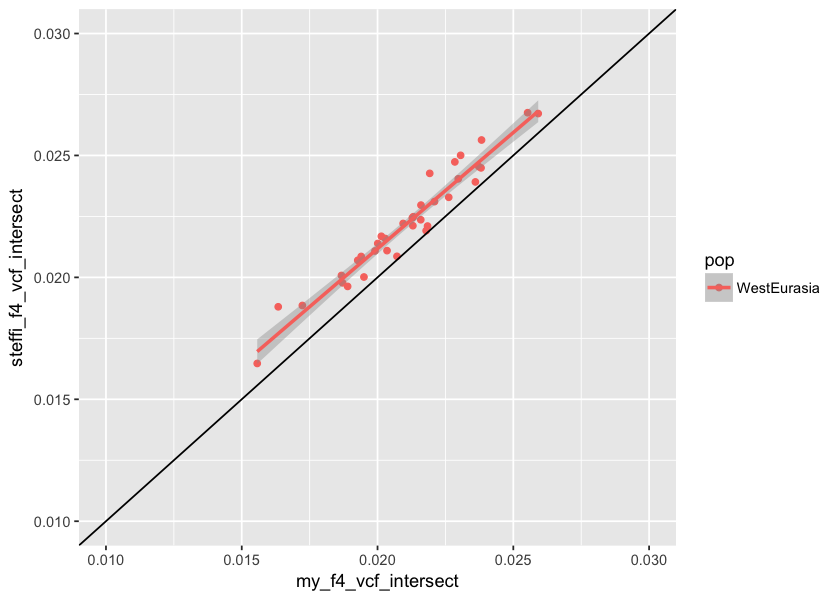

In [23]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_intersect, steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

Both sets were calculated on the same data, but one using Admixtools (x axis) and another using Steffi's scripts (y axis).

**This must reflect some difference in the f4 calculation.** Steffi calculates both f4 numerator and denominator separately and then divides them. Could this be part of an explanation?

I will have to calculate individual ABBA/BABA counts using Admixtools to see if that is the case.

**UPDATE:** The plot of Steffi's and my f4 on Qiaomei's data suggests that the calculation is the same? <font color="red">How is the plot above even possible then?</font> Steffi changed her code in the meantime - is it possible that the most recent calculation would give a different result now? I should ask her to rerun her analysis again.

## My f4 on 250k subset of Qiaomei's data vs my f4 on subset of Steffi's VCF (~250k sites)

What happens if we subset even Qiaomei's EIGENSTRAT dataset to the same set of sites that remain in Steffi's VCF after intersecting?

Is there a difference in data processing?

In [401]:
EIGENSTRAT_DIR <- "../raw_data/eigenstrat_all//"
EIGENSTRAT <- paste0(EIGENSTRAT_DIR, "UPA_merged_all")

EIGENSTRAT_INTERSECT <- paste0(EIGENSTRAT, "_intersect")

In [32]:
suppressMessages(
    subset_sites(EIGENSTRAT, EIGENSTRAT_INTERSECT, pos_file="../raw_data/merged_vcfs/sites.pos")
)

[1] TRUE

In [402]:
my_f4_qiaomei_intersect <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                                 prefix=EIGENSTRAT_INTERSECT) %>% 
    rename(my_f4_qiaomei_intersect=alpha)

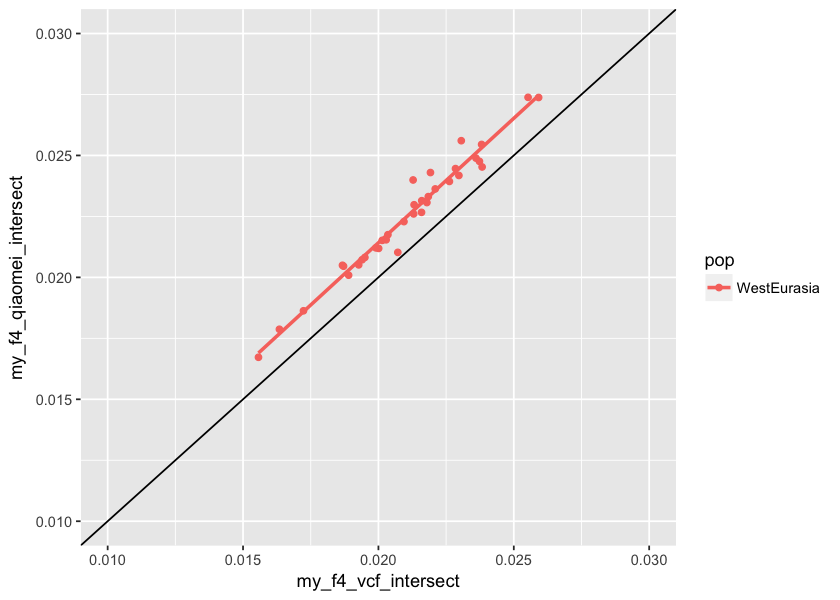

In [24]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_intersect, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

This is strange. So the "Any potential difference is caused by the computation of Admixtools vs Steffi's script." is not correct?

Huh, both my f4 on subset of Qiaomei's data and Steffi's f4 on her subset of her VCF are higher than my f4 on the VCF subset.

## My f4 on 250k sites from Qiaomei's data vs Steffi's 250k intersect on her data

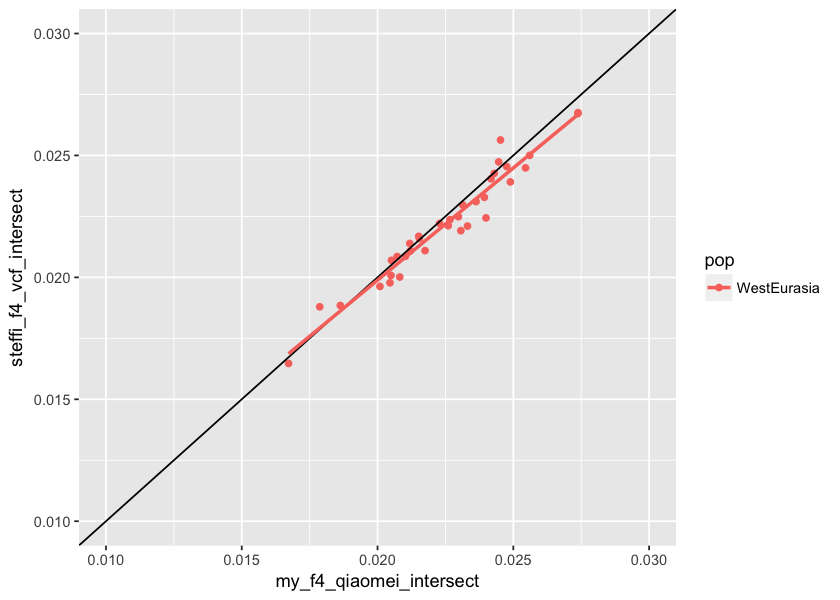

In [16]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_qiaomei_intersect, steffi_f4, by=c("X"="name")) %>%
filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_qiaomei_intersect, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## All sites vs subset on Steffi's data, also using Qiaomei's data

In [37]:
my_f4_vcf_all <- qpF4ratio(X=filter(samples, !pop %in% c("EMH", "Oceania"))$name, A="new_Altai", B="new_Vindija", C="Mbuti", O="Chimp",
                           prefix=STEFFI_EIGENSTRAT) %>% 
    rename(my_f4_vcf_all=alpha)

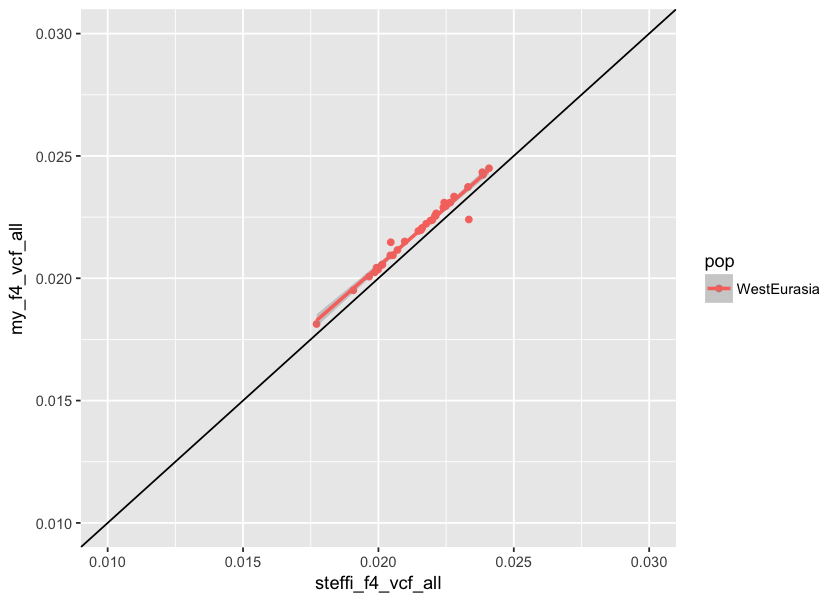

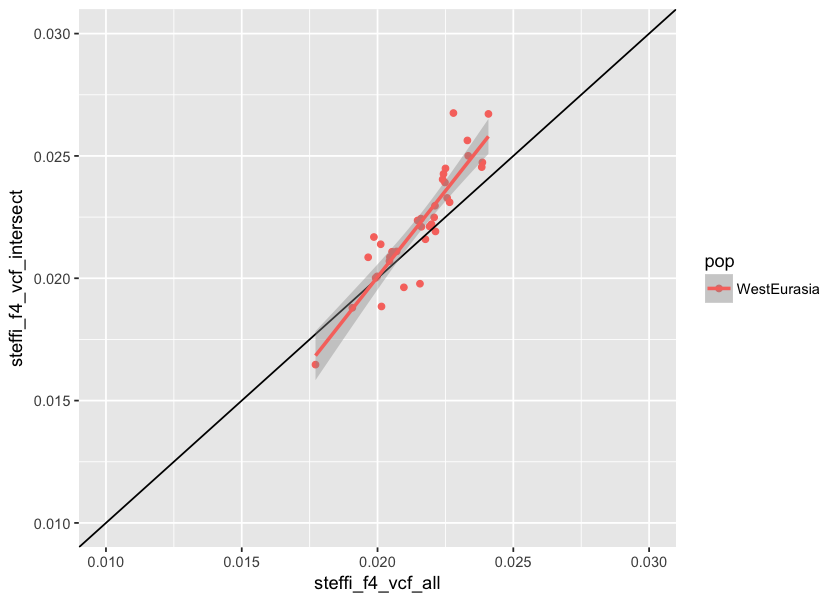

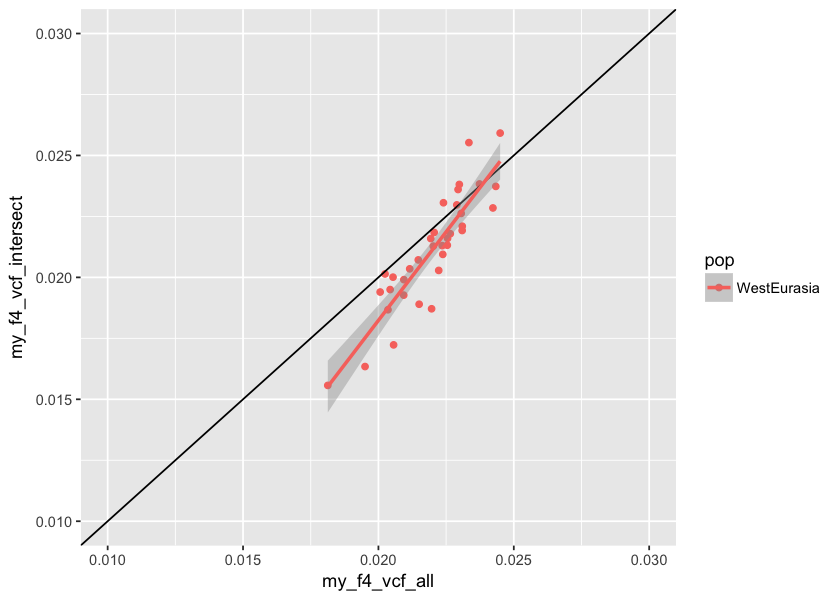

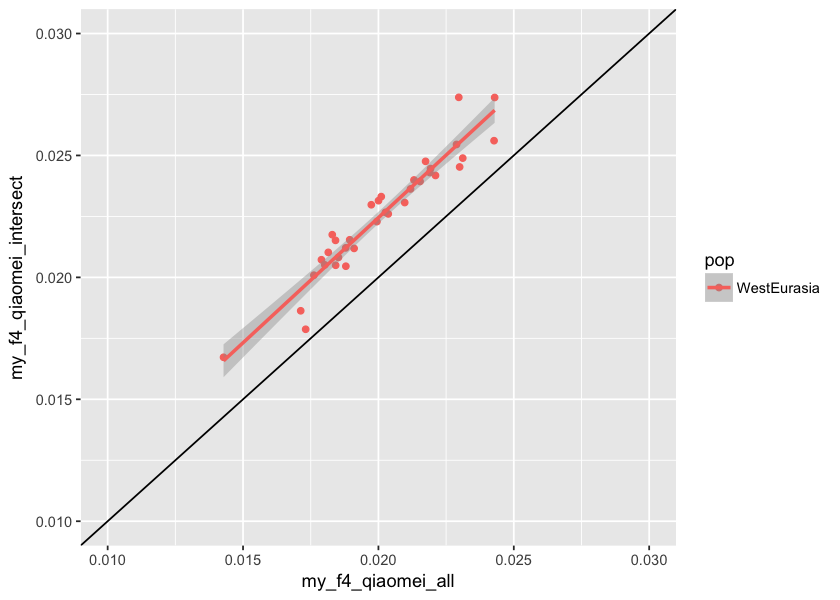

In [17]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_all, steffi_f4, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>%
    ggplot(aes(steffi_f4_vcf_all, my_f4_vcf_all, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

steffi_f4 %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(steffi_f4_vcf_all, steffi_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_all, my_f4_vcf_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_vcf_all, my_f4_vcf_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

inner_join(my_f4_qiaomei_all, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia") %>% 
    ggplot(aes(my_f4_qiaomei_all, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

Why is the correlation screwed up when using Steffi's VCF (both using her f4 and my f4), but not when I use Qiaomei's EIGENSTRAT data?

Also - subsetting 2.2M sites to the intersect with Steffi's data increases the overall Nea. ancestry levels - what is so special about these sites? Only a handful of them intersect (250k) out of Steffi's total of 2.3M sites - why?

# Why is Steffi's f4 on her VCF so similar to my f4 on Qiaomei's data?

The fact that the f4 results line up when I estimate f4 using Admixtools on Qiaomei's data and when Steffi estimates f4 on her data suggests there might be a difference in both the actual calcuation and in the data processing as well. Let's look into both of these options.

Especially this results is weird, my f4 gives different result on Steffi's and Qiaomei's VCF:

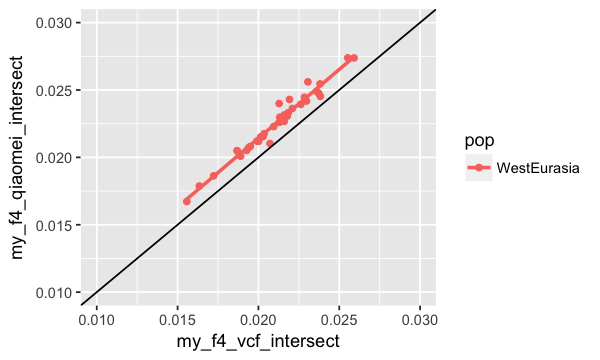

In [18]:
options(repr.plot.width=5, repr.plot.height=3)

inner_join(my_f4_vcf_intersect, my_f4_qiaomei_intersect, by="X") %>% inner_join(samples, by=c("X"="name")) %>%
filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, my_f4_qiaomei_intersect, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    geom_smooth(method="lm", se=FALSE) +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))

## Checking the genotypes between Qiaomei's EIGENSTRAT and Steffi's VCF

In [25]:
suppressMessages({

qiaomei_geno <- read_geno(paste0(EIGENSTRAT_INTERSECT, ".geno"), paste0(EIGENSTRAT_INTERSECT, ".ind"))
vcf_geno <- read_geno(paste0(STEFFI_EIGENSTRAT_INTERSECT, ".geno"), paste0(STEFFI_EIGENSTRAT_INTERSECT, ".ind"))

})

In [26]:
shared_samples <- intersect(names(qiaomei_geno), names(vcf_geno))

suppressMessages({
    
qiaomei_geno <- select(qiaomei_geno, one_of(shared_samples)) %>%
    bind_cols(read_snp(paste0(EIGENSTRAT_INTERSECT, ".snp")), .) %>%
    select(-id, -gen)

vcf_geno <- select(vcf_geno, one_of(shared_samples)) %>%
    bind_cols(read_snp(paste0(STEFFI_EIGENSTRAT_INTERSECT, ".snp")), .) %>%
    select(-id, -gen)

})

In [27]:
table(qiaomei_geno$new_Vindija, vcf_geno$new_Vindija)
table(qiaomei_geno$new_Altai, vcf_geno$new_Altai)
table(qiaomei_geno$Chimp, vcf_geno$Chimp)

   
         0      1      2
  0 108052      0      0
  1      0  15118      0
  2      0      0 130999

   
         0      1      2
  0  99383      0      0
  1      0  38777      0
  2      0      0 116009

   
         0      2
  0 113180    608
  2    451 133279
  9   3831   2820

In [10]:
mismatch_gt <- function(ind) {
    mismatch_pos <- (qiaomei_geno$ref != vcf_geno$ref) | (qiaomei_geno$alt != vcf_geno$alt)

    cat("Before filtering:\n")
    print(table(qiaomei_geno[[ind]], vcf_geno[[ind]]))

    cat("\nAfter filtering:\n")
    print(table(qiaomei_geno[!mismatch_pos, ][[ind]], vcf_geno[!mismatch_pos, ][[ind]]))

    mismatches <- bind_cols(
        select(qiaomei_geno, chrom, pos, ref_qiaomei=ref, alt_qiaomei=alt)[mismatch_pos, ],
        select(vcf_geno, ref_steffi=ref, alt_steffi=alt)[mismatch_pos, ],
        setNames(qiaomei_geno[mismatch_pos, c(ind, "Chimp")], c("qiaomei_GT", "qiaomei_Chimp")),
        setNames(vcf_geno[mismatch_pos, c(ind, "Chimp")], c("vcf_GT", "vcf_Chimp"))
    ) %>% filter(qiaomei_GT != 9 & vcf_GT != 9) %>%
        select(chrom, pos, ref_qiaomei, ref_steffi, alt_qiaomei, alt_steffi, qiaomei_GT, vcf_GT, qiaomei_Chimp, vcf_Chimp)

    cat("\nExample of non-sense SNPs (total", sum(mismatch_pos), "):\n\n")
    mismatches
}

In [783]:
mismatch_gt("Chimp") %>% head

Before filtering:
   
         0      2
  0 113180    608
  2    451 133279
  9   3831   2820

After filtering:
   
         0      2
  0 113172      0
  2      0 133271

Example of non-sense SNPs (total 7726 ):



chrom,pos,ref_qiaomei,alt_qiaomei,ref_steffi,alt_steffi,qiaomei_GT,vcf_GT
1,7152038,G,A,G,A,0,2
1,10922579,C,T,T,C,0,2
1,14804654,A,G,G,A,0,2
1,15489817,A,G,G,A,2,0
1,18611016,T,C,C,T,0,2
1,20613458,C,T,T,C,0,2


In [11]:
mismatch_gt("S_French-1") %>% head

Before filtering:
   
         0      1      2      9
  0  42520      0    822    225
  1      8  61559     16    375
  2     84      7 147938    592
  9      1      8      7      7

After filtering:
   
         0      1      2      9
  0  42520      0      7    223
  1      8  61190     16    373
  2      0      7 147918    591
  9      1      7      6      7

Example of non-sense SNPs (total 1295 ):



chrom,pos,ref_qiaomei,ref_steffi,alt_qiaomei,alt_steffi,qiaomei_GT,vcf_GT,qiaomei_Chimp,vcf_Chimp
1,4673937,C,T,T,C,0,2,9,0
1,8222156,G,A,A,G,1,1,9,0
1,10922579,C,T,T,C,0,2,0,2
1,14804654,A,G,G,A,0,2,0,2
1,15489817,A,G,G,A,1,1,2,0
1,18611016,T,C,C,T,1,1,0,2


In [763]:
c <- sapply(intersect(names(qiaomei_geno), names(vcf_geno))[-(1:4)], function(s) {
    sites <- (qiaomei_geno[[s]] != 9) & (vcf_geno[[s]] != 9) & (qiaomei_geno$ref == vcf_geno$ref) & (qiaomei_geno$alt == vcf_geno$alt)
    q <- qiaomei_geno[sites, ]
    v <- vcf_geno[sites, ]
    cor(q[[s]], v[[s]])
})

In [912]:
head(c)

Chimp    Loschbour    Ust_Ishim    B_Dinka-3  S_Bengali-2 S_Estonian-1 
   0.9995753    0.9996439    0.9998736    0.9997157    0.9997662    0.9997457

In [14]:
d <- sapply(intersect(names(qiaomei_geno), names(vcf_geno))[-(1:4)][1:20], function(s) {
    sites <- (qiaomei_geno[[s]] != 9) & (vcf_geno[[s]] != 9) &
             (qiaomei_geno$ref == vcf_geno$ref) &
             (qiaomei_geno$alt == vcf_geno$alt)
    q <- qiaomei_geno[sites, ]
    v <- vcf_geno[sites, ]
    mean(q[[s]] != v[[s]])
})

In [16]:
head(d)

Chimp    Loschbour    Ust_Ishim    B_Dinka-3  S_Bengali-2 S_Estonian-1 
0.0002109576 0.0004496331 0.0001465439 0.0002433750 0.0001863519 0.0002060214

### Write the coordinates of SNPs screwed up in Qiaomei's data

In [28]:
SCREWEDREF_FILE <- paste0(EIGENSTRAT_INTERSECT, ".screwedREF.snp")

In [32]:
read_snp(paste0(EIGENSTRAT_INTERSECT, ".snp")) %>% 
    filter((qiaomei_geno$ref != vcf_geno$ref)) %>% 
    filter(chrom %in% 1:22) %>%
    write_tsv(SCREWEDREF_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character()
)


In [29]:
SCREWEDCHIMP_FILE <- paste0(EIGENSTRAT_INTERSECT, ".screwedChimp.snp")

In [34]:
read_snp(paste0(EIGENSTRAT_INTERSECT, ".snp")) %>% 
    filter((qiaomei_geno$Chimp != vcf_geno$Chimp)) %>% 
    filter(chrom %in% 1:22) %>%
    write_tsv(SCREWEDCHIMP_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character()
)


In [30]:
SCREWEDALL_FILE <- paste0(EIGENSTRAT_INTERSECT, ".screwedall.snp")

In [36]:
read_snp(paste0(EIGENSTRAT_INTERSECT, ".snp")) %>% 
    filter((qiaomei_geno$Chimp != vcf_geno$Chimp) | (qiaomei_geno$ref != vcf_geno$ref) | (qiaomei_geno$alt != vcf_geno$alt)) %>% 
    filter(chrom %in% 1:22) %>%
    write_tsv(SCREWEDALL_FILE, col_names=FALSE)

Parsed with column specification:
cols(
  id = col_character(),
  chrom = col_integer(),
  gen = col_double(),
  pos = col_integer(),
  ref = col_character(),
  alt = col_character()
)


## ABBA and BABA counts

#### my stuff

In [18]:
martin_f4_qiaomei_intersect <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=EIGENSTRAT_INTERSECT, f4mode=TRUE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_qiaomei_intersect")

martin_f4_vcf_intersect <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=STEFFI_EIGENSTRAT_INTERSECT, f4mode=TRUE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_vcf_intersect")

In [37]:
martin_f4_qiaomei_intersect_fixref <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=EIGENSTRAT_INTERSECT, f4mode=TRUE, badsnp=SCREWEDREF_FILE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_qiaomei_intersect_fixref")

In [38]:
martin_f4_qiaomei_intersect_fixchimp <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=EIGENSTRAT_INTERSECT, f4mode=TRUE, badsnp=SCREWEDCHIMP_FILE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_qiaomei_intersect_fixchimp")

In [39]:
martin_f4_qiaomei_intersect_fixall <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=EIGENSTRAT_INTERSECT, f4mode=TRUE, badsnp=SCREWEDALL_FILE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_qiaomei_intersect_fixall")

In [40]:
martin_f4_vcf_intersect_fixall <-
    qpDstat(W=c("new_Vindija", filter(samples, pop == "WestEurasia")$name), X="Mbuti", Y="new_Altai", Z="Chimp",
            prefix=STEFFI_EIGENSTRAT_INTERSECT, f4mode=TRUE, badsnp=SCREWEDALL_FILE) %>%
    mutate(f4_ratio=f4/filter(., W == "new_Vindija")$f4) %>%
    select(name=W, ABBA, BABA, f4, f4_ratio, z=Zscore) %>%
    mutate(what="martin_vcf_intersect_fixall")

#### Steffi's stuff

In [27]:
steffi_f4_ratios_intersect <- filter(steffi_df, pop3 == "Altai", pop2 == "Mbuti", set == "steffi_f4_vcf_intersect") %>%
    filter(name %in% c("Vindija", filter(samples, pop == "WestEurasia")$name)) %>%
    mutate(name=ifelse(name == "Vindija", "new_Vindija", name)) %>% 
    select(name, ABBA=abba, BABA=baba, f4, f4_ratio, z) %>%
    mutate(what="steffi_vcf_intersect")

steffi_f4_ratios_all <- filter(steffi_df, pop3 == "Altai", pop2 == "Mbuti", set == "steffi_f4_vcf_all") %>%
    filter(name %in% c("Vindija", filter(samples, pop == "WestEurasia")$name)) %>%
    mutate(name=ifelse(name == "Vindija", "new_Vindija", name)) %>% 
    select(name, ABBA=abba, BABA=baba, f4, f4_ratio, z) %>%
    mutate(what="steffi_vcf_all")

#### comparisons

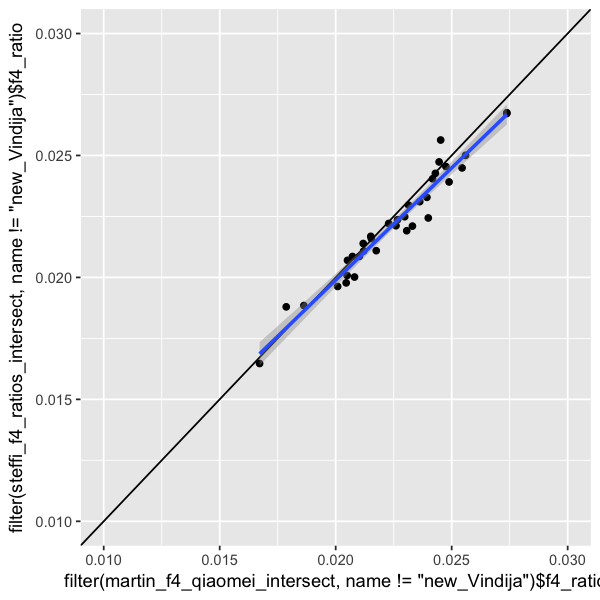

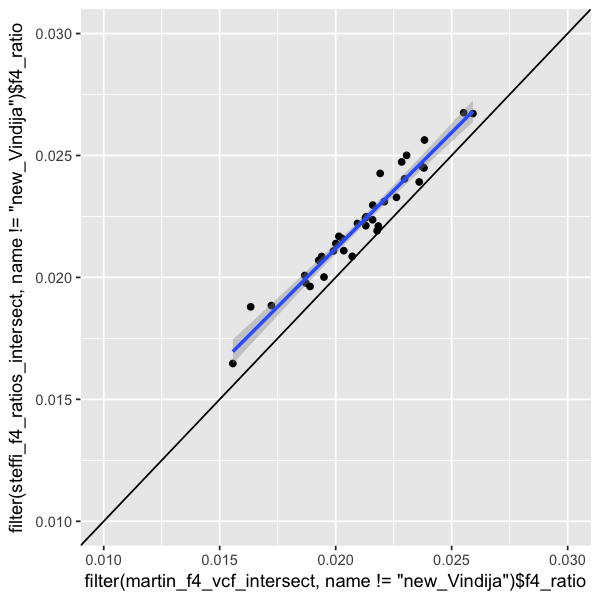

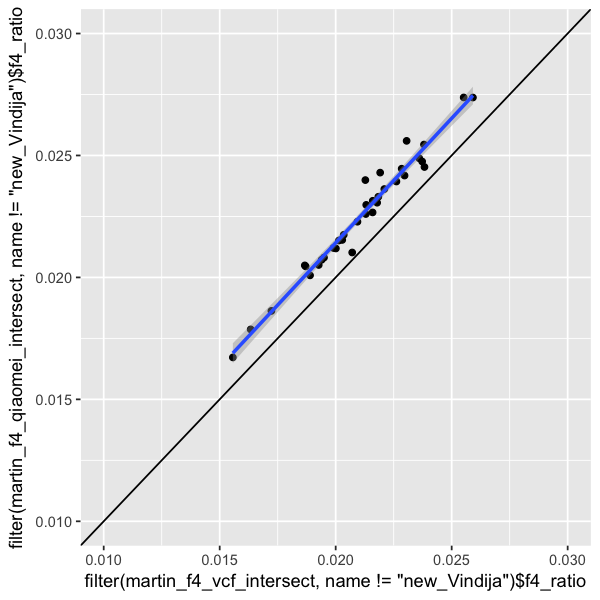

In [31]:
options(repr.plot.width=5, repr.plot.height=5)

qplot(filter(martin_f4_qiaomei_intersect, name != "new_Vindija")$f4_ratio,
      filter(steffi_f4_ratios_intersect, name != "new_Vindija")$f4_ratio) +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    xlim(0.01, 0.03) +
    ylim(0.01, 0.03)

options(repr.plot.width=5, repr.plot.height=5)

qplot(filter(martin_f4_vcf_intersect, name != "new_Vindija")$f4_ratio,
      filter(steffi_f4_ratios_intersect, name != "new_Vindija")$f4_ratio) +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    xlim(0.01, 0.03) +
    ylim(0.01, 0.03)

options(repr.plot.width=5, repr.plot.height=5)

qplot(filter(martin_f4_vcf_intersect, name != "new_Vindija")$f4_ratio,
      filter(martin_f4_qiaomei_intersect, name != "new_Vindija")$f4_ratio) +
    geom_abline(slope=1) +
    geom_smooth(method="lm") +
    xlim(0.01, 0.03) +
    ylim(0.01, 0.03)

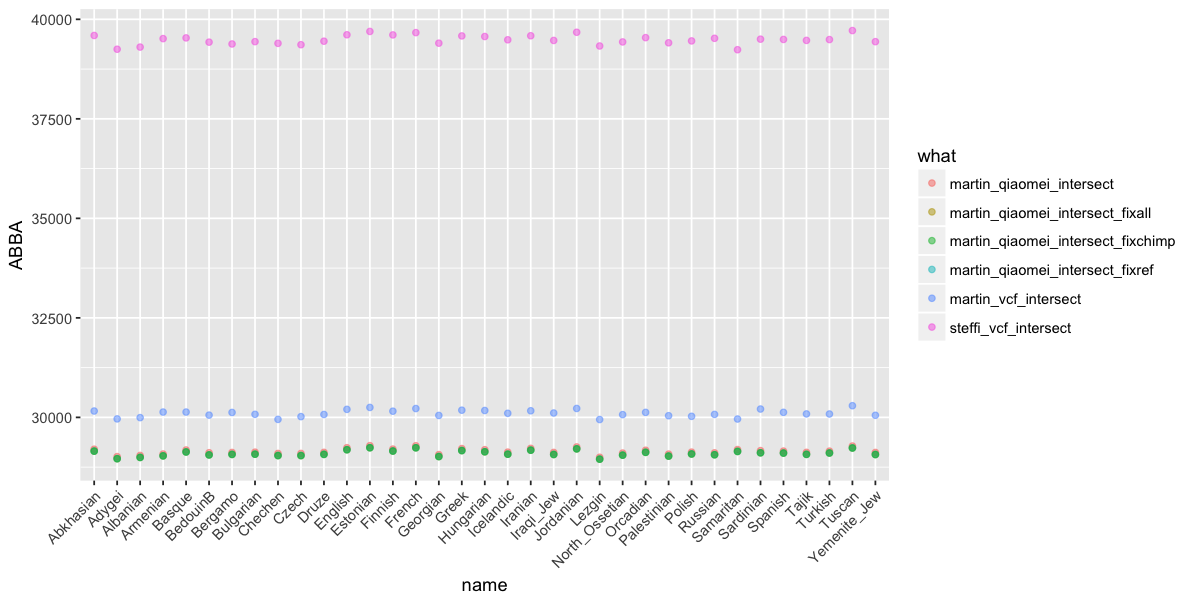

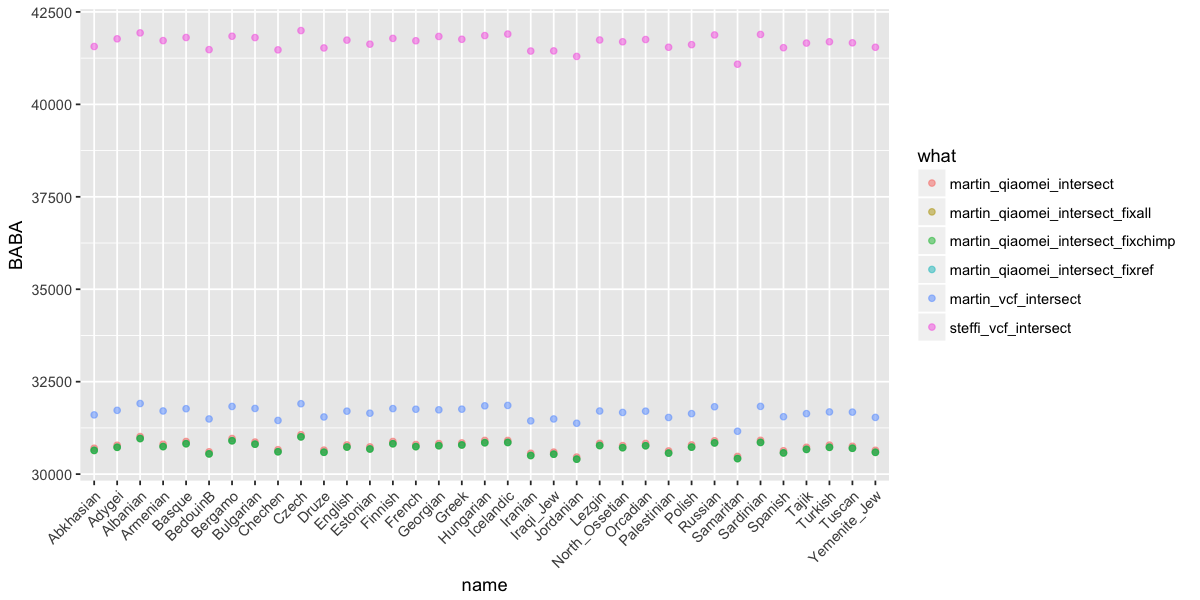

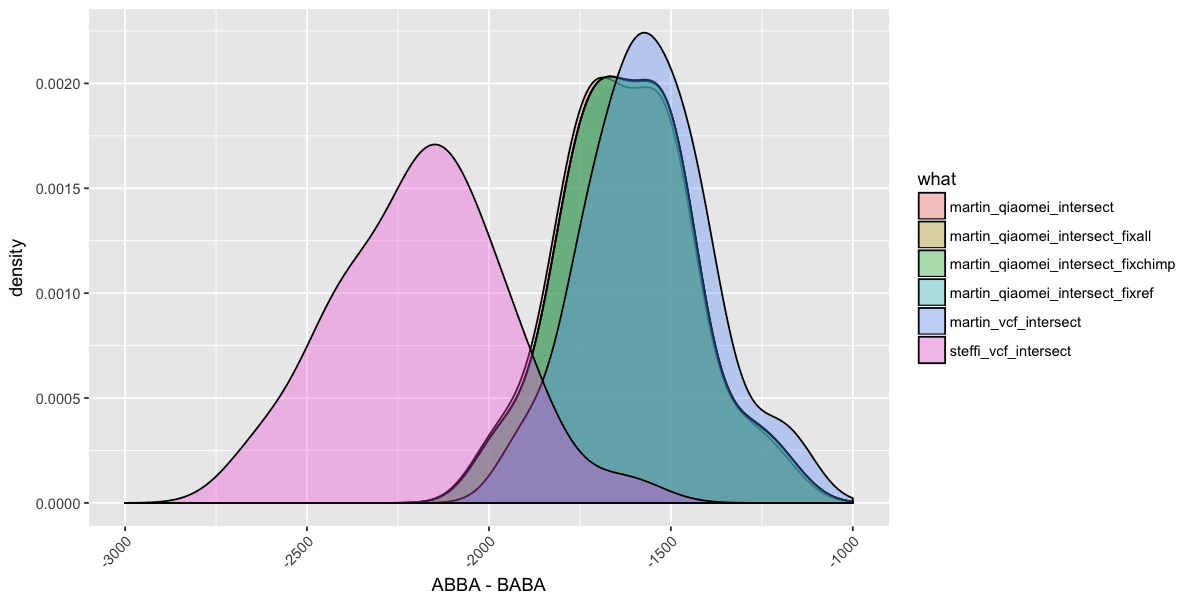

In [32]:
options(repr.plot.width=10, repr.plot.height=5)

bind_rows(martin_f4_qiaomei_intersect, martin_f4_qiaomei_intersect_fixall, martin_f4_qiaomei_intersect_fixref, martin_f4_qiaomei_intersect_fixchimp, martin_f4_vcf_intersect, steffi_f4_ratios_intersect) %>%
filter(!str_detect(name, "new_Vindija")) %>% 
ggplot(aes(name, ABBA, color=what)) +
    geom_point(alpha=1/2) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) 

options(repr.plot.width=10, repr.plot.height=5)

bind_rows(martin_f4_qiaomei_intersect, martin_f4_qiaomei_intersect_fixall, martin_f4_qiaomei_intersect_fixref, martin_f4_qiaomei_intersect_fixchimp, martin_f4_vcf_intersect, steffi_f4_ratios_intersect) %>%
filter(!str_detect(name, "new_Vindija")) %>% 
ggplot(aes(name, BABA, color=what)) +
    geom_point(alpha=1/2) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

options(repr.plot.width=10, repr.plot.height=5)

bind_rows(martin_f4_qiaomei_intersect, martin_f4_qiaomei_intersect_fixall, martin_f4_qiaomei_intersect_fixref, martin_f4_qiaomei_intersect_fixchimp, martin_f4_vcf_intersect, steffi_f4_ratios_intersect) %>%
filter(!str_detect(name, "new_Vindija")) %>% 
ggplot(aes(ABBA-BABA, fill=what)) +
    geom_density(alpha=1/3) +
    theme(axis.text.x=element_text(angle=45, hjust=1)) +
    xlim(-3000, -1000)

1. Steffi's calculation has a **much** higher number of ABBA and BABA sites than `martin_vcf_intersect`, which has *the same data*. **Why?**

* `martin_qiaomei_intersect*` and `martin_vcf_intersect` do not contain **exactly** same GTs. This is most likely why they lead to slightly different ABBA BABA counts.


In [42]:
calc_f4 <- function(sample, df, count=FALSE) {
    f4 <- (filter(df, name == sample)$ABBA - filter(df, name == sample)$BABA)
    
    if (count) {
        return(f4)
    } else {
        return(f4 / nrow(qiaomei_geno))
    }
}

In [43]:
filter(steffi_f4_ratios_intersect, name %in% c("new_Vindija", "Abkhasian", "Adygei", "Albanian"))

filter(martin_f4_vcf_intersect, name %in% c("new_Vindija", "Abkhasian", "Adygei", "Albanian"))
filter(martin_f4_qiaomei_intersect, name %in% c("new_Vindija", "Abkhasian", "Adygei", "Albanian"))

name,ABBA,BABA,f4,f4_ratio,z,what
Abkhasian,39594.198,41564.91,1970.708,0.02001503,6.795423,steffi_vcf_intersect
Adygei,39248.771,41772.65,2523.875,0.02563313,8.537732,steffi_vcf_intersect
Albanian,39302.635,41933.28,2630.646,0.02671752,7.621343,steffi_vcf_intersect
new_Vindija,6632.854,105094.29,98461.437,1.00000000,0.000000,steffi_vcf_intersect


name,ABBA,BABA,f4,f4_ratio,z,what
new_Vindija,4818,78815,0.291139,1.00000000,100.000,martin_vcf_intersect
Abkhasian,30160,31602,0.005676,0.01949584,6.060,martin_vcf_intersect
Adygei,29962,31725,0.006937,0.02382711,7.120,martin_vcf_intersect
Albanian,29994,31910,0.007545,0.02591546,6.866,martin_vcf_intersect


name,ABBA,BABA,f4,f4_ratio,z,what
new_Vindija,4714,76748,0.291028,1.00000000,100.000,martin_qiaomei_intersect
Abkhasian,29201,30701,0.006057,0.02081243,6.579,martin_qiaomei_intersect
Adygei,29015,30782,0.007138,0.02452685,7.509,martin_qiaomei_intersect
Albanian,29044,31016,0.007967,0.02737537,7.393,martin_qiaomei_intersect


In [46]:
calc_f4("new_Vindija", steffi_f4_ratios_intersect)

[1] -0.3873857

In [49]:
calc_f4("new_Vindija", martin_f4_vcf_intersect)

[1] -0.2911331

In [51]:
calc_f4("Abkhasian", steffi_f4_ratios_intersect)

[1] -0.007753535

In [867]:
calc_f4("Abkhasian", martin_f4_vcf_intersect)

[1] -0.005673391

In [876]:
calc_f4("Abkhasian", steffi_f4_ratios_intersect)/calc_f4("new_Vindija", steffi_f4_ratios_intersect)

[1] 0.02001503

In [871]:
calc_f4("Abkhasian", martin_f4_vcf_intersect)/calc_f4("new_Vindija", martin_f4_vcf_intersect)

[1] 0.01948728

In [872]:
calc_f4("Abkhasian", martin_f4_qiaomei_intersect)/calc_f4("new_Vindija", martin_f4_qiaomei_intersect)

[1] 0.0208235

In [50]:
save.image("../RData/admixtools_debugging.RData")

In [137]:
suppressMessages({
    
steffi_df2 <- bind_rows(
    read_table2("../raw_data/steffi/results_usti_array_dtoolbox")                   %>% mutate(set="steffi_f4_vcf_NO_chimp_eq_orang_sgdp1"),
    read_table2("../raw_data/steffi/results_usti_array_dtoolbox_chimp_orang")       %>% mutate(set="steffi_f4_vcf_chimp_eq_orang_sgdp1"),
    read_table2("../raw_data/steffi/results_usti_array_dtoolbox_sgdp0_chimp_orang") %>% mutate(set="steffi_f4_vcf_chimp_eq_orang_sgdp0"),
    ) %>%
    filter(pop3 == "AltaiNeandertal", pop2 == "Mbuti", pop4 == "chimp_orang") %>% 
    mutate(pop1=ifelse(pop1 == "Ust_Ishim", "UstIshim", pop1)) %>% 
    rename(name=pop1) %>%
    left_join(samples) %>%
    select(-n_sites_f4, -age) %>%
    filter(!is.na(pop))

    new_steffi_f4 <- steffi_df2 %>% select(name, f4_ratio, set, pop) %>% spread(set, f4_ratio)
})

In [116]:
table(steffi_df$set)


steffi_f4_vcf_NO_chimp_eq_orang_sgdp1    steffi_f4_vcf_chimp_eq_orang_sgdp0 
                                  110                                   110 
   steffi_f4_vcf_chimp_eq_orang_sgdp1 
                                  110 

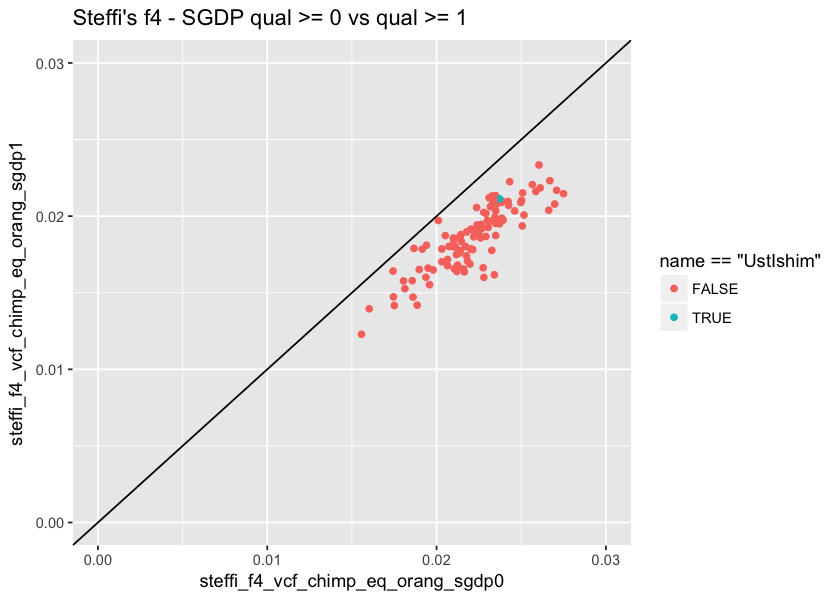

In [132]:
options(repr.plot.width=7, repr.plot.height=5)

steffi_f4 %>% 
    ggplot(aes(steffi_f4_vcf_chimp_eq_orang_sgdp0, steffi_f4_vcf_chimp_eq_orang_sgdp1, color=name == "UstIshim")) +
    geom_point() +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0.0, 0.03), y=c(0.0, 0.03)) +
    ggtitle("Steffi's f4 - SGDP qual >= 0 vs qual >= 1")

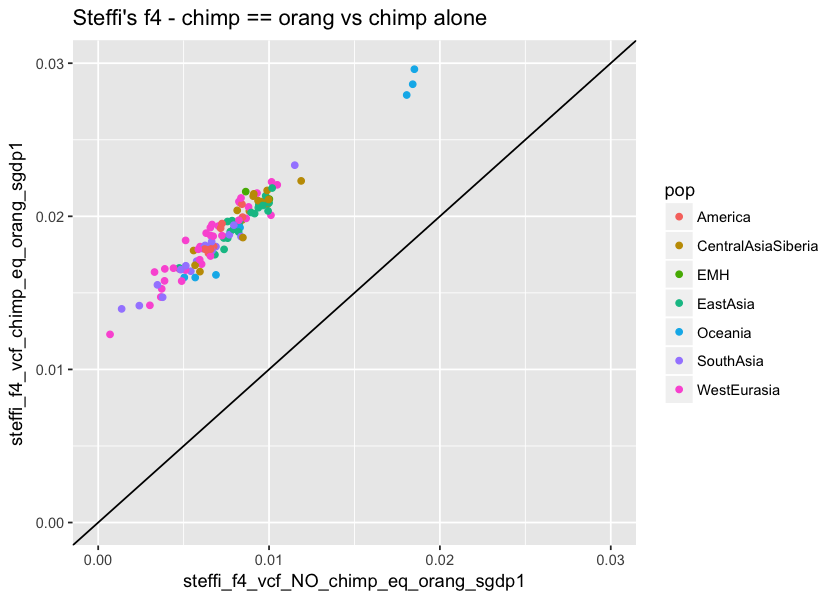

In [134]:
options(repr.plot.width=7, repr.plot.height=5)

steffi_f4 %>% 
    ggplot(aes(steffi_f4_vcf_NO_chimp_eq_orang_sgdp1, steffi_f4_vcf_chimp_eq_orang_sgdp1, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
    coord_cartesian(x=c(0.0, 0.03), y=c(0.0, 0.03)) +
    ggtitle("Steffi's f4 - chimp == orang vs chimp alone")

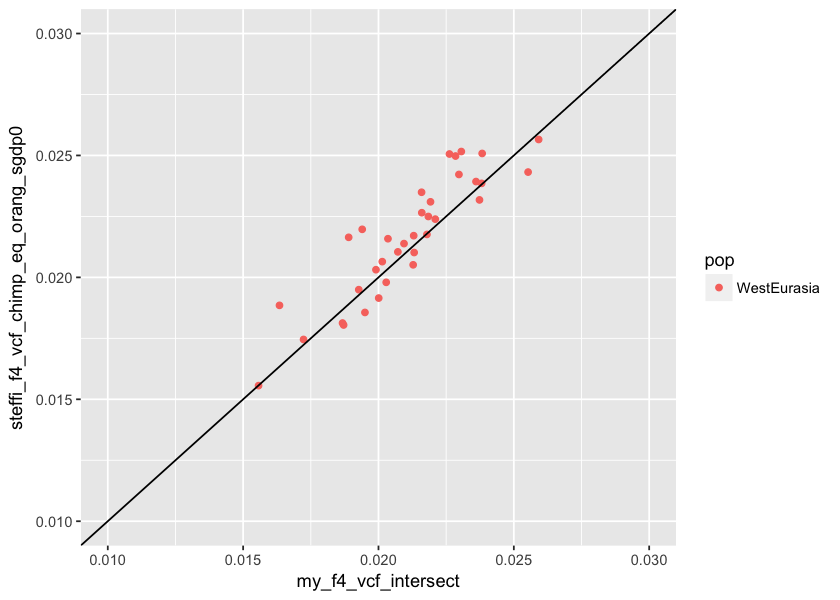

In [141]:
options(repr.plot.width=7, repr.plot.height=5)

inner_join(my_f4_vcf_intersect, new_steffi_f4, by=c("X"="name")) %>% filter(pop == "WestEurasia")  %>% 
    ggplot(aes(my_f4_vcf_intersect, steffi_f4_vcf_chimp_eq_orang_sgdp0, color=pop)) +
    geom_point() +
    geom_abline(slope=1) +
#    geom_smooth(method="lm") +
    coord_cartesian(x=c(0.01, 0.03), y=c(0.01, 0.03))